In [1]:
import random

In [2]:
import argparse, os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import cucim
import cucim.skimage.metrics as met

import utils
import data.HCP_dataset_h5_arb as HCP_dataset

number of common Subjects  171


7T scan resolution : 173, 207, 173

3T scan resolution : 145, 174, 145

In [3]:
parser = argparse.ArgumentParser(description="DTI_ARB")
parser.add_argument("--block_size", type=tuple, default=(32,32,16),
                    help="Block Size")
parser.add_argument("--test_size", type=tuple, default=(64,64,16),
                    help="test_size")
parser.add_argument("--crop_depth", type=int, default=15,
                    help="crop across z-axis")
parser.add_argument("--dir", type=str,
                    help="dataset_directory")
parser.add_argument("--batch_size", type=int,
                    help="dataset_directory")
parser.add_argument("--sort", type=bool,
                    help="dataset_directory")
parser.add_argument("--debug", type=bool,
                    help="dataset_directory")
parser.add_argument("--preload", type=bool,
                    help="dataset_directory")
parser.add_argument("--scale", type=tuple, default=(2,1.5,1),
                    help="test_size")
parser.add_argument("--ret_points", type=bool, default=False,
                    help="return box point of crops")
parser.add_argument("--thres", type=float, default=0.65,
                    help="threshold for blk emptiness")
args = list(parser.parse_known_args())[0]
args.preload = True
args.ret_points = True
args.debug = True
args.dir = "/storage"
args.batch_size = 4
args.sort = True
args.typ = 'upsampled'
args.scale = (2,2,2)
args.thres = 0.65
print(args)

Namespace(batch_size=4, block_size=(32, 32, 16), crop_depth=15, debug=True, dir='/storage', preload=True, ret_points=True, scale=(2, 2, 2), sort=True, test_size=(64, 64, 16), thres=0.65, typ='upsampled')


In [4]:
ids = utils.get_ids()
ids.sort()
ids = ids[:5]
dataset_hcp = HCP_dataset
dataset_hcp.load_data(args.dir,ids)
# testing_dataset = dataset_hcp.hcp_data_test(args,ids)

[1.2, 1.2, 1.2]


['100610', '102311', '102816', '104416', '105923']

In [5]:
training_dataset = dataset_hcp.hcp_data(args,ids)

100610 loaded
102311 loaded
102816 loaded
104416 loaded
105923 loaded


In [6]:
import h5py

loaded = {}
loaded_gt ={}

def load_path(base_dir,ids):
    base_dir_7t = [base_dir + "/HCP_7T/" + i   for i in ids]
    base_dir_3t = [base_dir + "/HCP_3T/" + i   for i in ids]
    path_7t = {}
    path_3t = {}
    for i in base_dir_7t:
        path_7t[i[-6:]] = {"h5" : i + "/" + i[-6:] + ".h5"
                        , "GT" : i + "/" + i[-6:] + "_GT.h5"}
    for i in base_dir_3t:
        path_3t[i[-6:]] = {"h5" : i + "/" + i[-6:] + ".h5"
                        , "upsampled" : i + "/" + i[-6:] + "_upsampled.h5"
                        , "GT" : i + "/" + i[-6:] + "_GT.h5"}
    path = {'3T': path_3t, "7T":  path_7t}
    p = list(path_7t.keys())
    q = list(path_3t.keys())
    common = list(set(p) & set(q))

    return path,len(common)

def load_data(base_dir,ids):
    ids.sort()
    path,tot = load_path(base_dir,ids)
    for i in ids:
        name = path['3T'][i]['h5']
        res_vol = h5py.File(name, 'r')
        # print(res_vol.keys())
        loaded[i] = {'vol0':res_vol.get('volumes0')[:]
                            ,'mask':res_vol.get('mask')[:]}
        
        name = path['7T'][i]['GT']
        res = h5py.File(name, 'r')
        # print(res.keys())
        loaded_gt[i] = {'ADC':res.get('ADC')[:]
                            ,'FA':res.get('FA')[:] 
                            ,'color_FA':res.get('color_FA')[:]}
        
        
        res_vol.close()
        res.close()

        name = path['7T'][i]['h5']
        res = h5py.File(name, 'r')
        loaded_gt[i]['vol0'] = res.get('volumes0')[:]
        loaded_gt[i]['mask'] = res.get('mask')[:]
        res_vol.close()
        res.close()


In [7]:
load_data('/storage',ids)

In [8]:
len(training_dataset)

245

In [9]:
x = training_dataset[0]
print(x[0].shape,x[1].shape,x[2].shape,x[3].shape,x[4].shape,x[5].shape)

(32, 32, 16, 7) (64, 64, 32) (64, 64, 32) (64, 64, 32, 3) (6,) (6,)


In [10]:
for j in range(len(training_dataset)):
    x = training_dataset[j]
    for i in range(4):
        l,h = x[i].min(),x[i].max()
        if(l<0 or h>1):
            print(l,h)

In [11]:
len(training_dataset)

245

In [12]:
def resize(data,ret_pnt = True):
    if(ret_pnt == False):
        x,y = [],[]
        for i in range(len(data)):
            x.append(data[i][0])
            y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
        return torch.from_numpy(np.stack(x)),torch.from_numpy(np.stack(y))
    else:
        x,y,z,vols = [],[],[],[]
        for i in range(len(data)):
            x.append(data[i][0])
            y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
            z.append({'lr':data[i][4],'hr':data[i][5]})
            vols.append(data[i][6])
        lr = torch.from_numpy(np.stack(x))
        pred = torch.from_numpy(np.stack(y))
        return lr,pred,z,vols

In [13]:
training_data_loader = DataLoader(dataset=training_dataset, batch_size=8, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)

In [14]:
len(training_data_loader)

30

In [15]:
temp = next(iter(training_data_loader))

In [16]:
temp[0].shape

torch.Size([8, 32, 32, 16, 7])

In [17]:
temp[1].shape

torch.Size([8, 64, 64, 32, 5])

In [18]:
temp[2]

[{'lr': array([45, 76, 48, 79, 16, 31]),
  'hr': array([ 86, 149,  96, 159,  32,  63])},
 {'lr': array([ 73, 104,  11,  42,  59,  74]),
  'hr': array([139, 202,  22,  85, 118, 149])},
 {'lr': array([ 41,  72,  75, 106,  43,  58]),
  'hr': array([ 78, 141, 150, 213,  86, 117])},
 {'lr': array([ 41,  72,  75, 106,  75,  90]),
  'hr': array([ 78, 141, 150, 213, 158, 189])},
 {'lr': array([ 9, 40, 43, 74, 43, 58]),
  'hr': array([ 17,  80,  86, 149,  86, 117])},
 {'lr': array([11, 42, 46, 77, 62, 77]),
  'hr': array([ 21,  84,  92, 155, 118, 149])},
 {'lr': array([ 75, 106,  46,  77,  30,  45]),
  'hr': array([142, 205,  92, 155,  57,  88])},
 {'lr': array([ 41,  72,  75, 106,  91, 106]),
  'hr': array([ 78, 141, 150, 213, 191, 222])}]

In [19]:
temp[3]

['104416',
 '105923',
 '105923',
 '100610',
 '105923',
 '102311',
 '102311',
 '100610']

In [20]:
temp[3]

['104416',
 '105923',
 '105923',
 '100610',
 '105923',
 '102311',
 '102311',
 '100610']

In [21]:
l=8
temp = next(iter(training_data_loader))

In [22]:

def interpolate(data,size):
#     print(data.shape)
    if(len(data.shape)==3):
        inp = torch.unsqueeze(data, 0)
#         print(inp.shape)
    else:
        inp = torch.permute(data, (3,0,1,2))
    inp = torch.unsqueeze(inp, 0)
    interpolated = torch.nn.functional.interpolate(inp,size = torch.Size(size))
    interpolated = torch.permute(interpolated, (2,3,4,1,0))
    
    if(len(data.shape)==3):
        interpolated = torch.squeeze(interpolated)
    return torch.squeeze(interpolated)

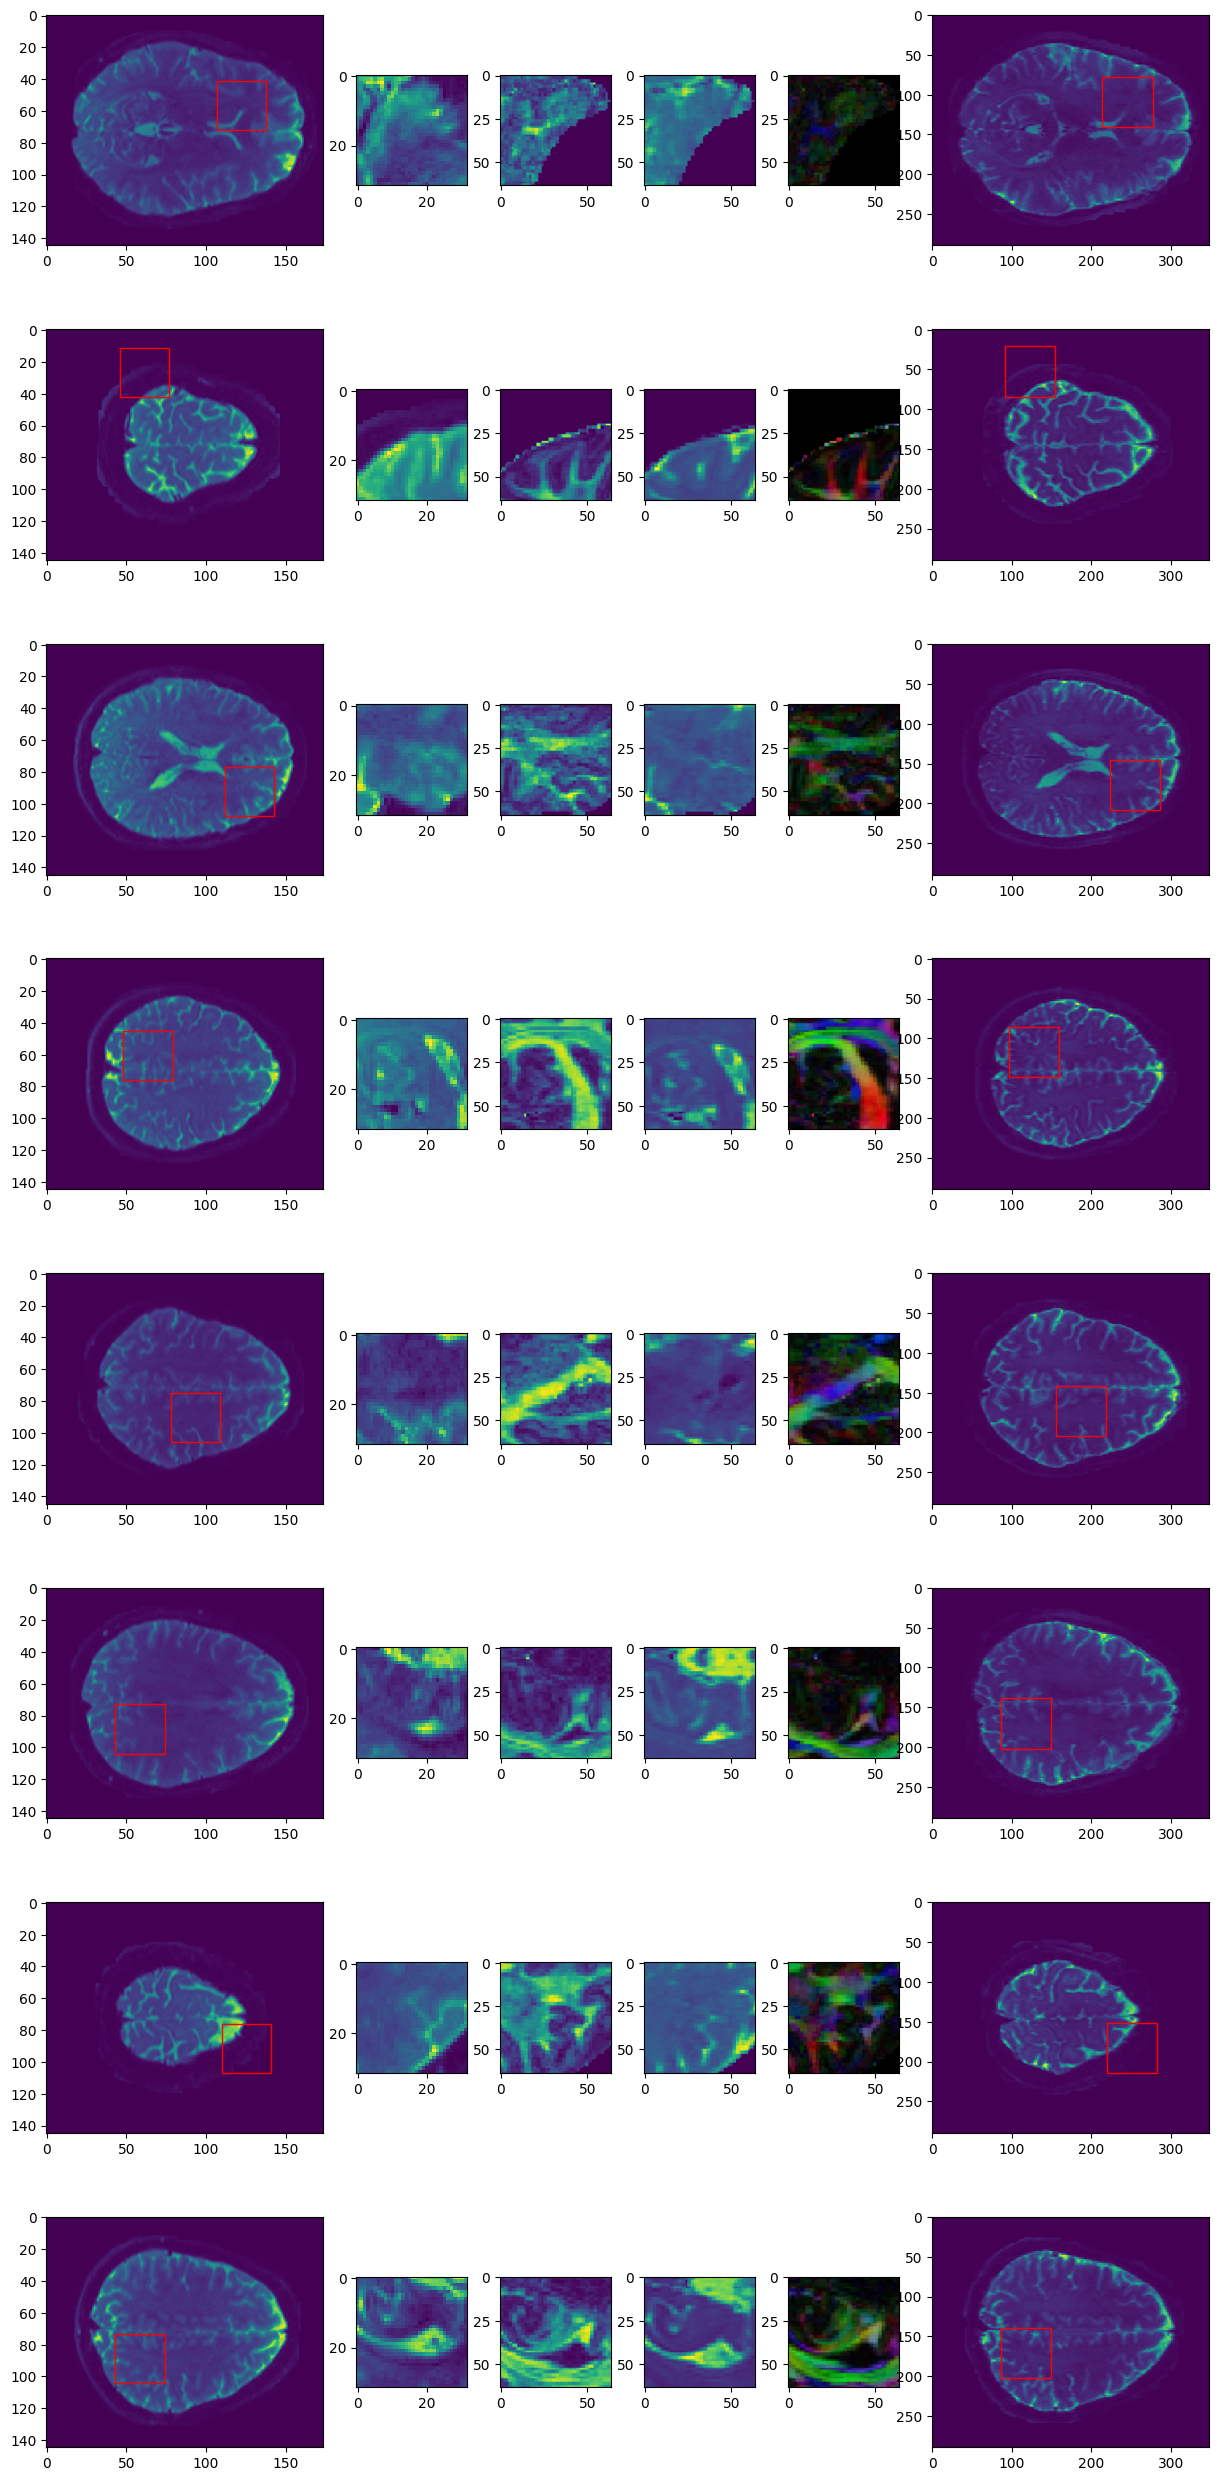

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random
temp = next(iter(training_data_loader))
fig, ax = plt.subplots(l,6,gridspec_kw={'width_ratios': [2.5, 1,1,1,1,2.5]})

# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*l)
 
# set width of each subplot as 8
fig.set_figwidth(15)

for i in range(l):
    
    data_3t= loaded[temp[3][i]]['vol0']
    
    size = [int(args.scale[i] * data_3t.shape[i]) for i in range(3)]
    data_7t= interpolate(torch.from_numpy(loaded_gt[temp[3][i]]['vol0']),size = size)
    img_pnt = temp[2][i]['lr']
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    
    ax[i][0].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][0].imshow(data_3t[:,:,sliceee,0])
    ax[i][1].imshow(temp[0][i,:,:,0,0])
    ax[i][2].imshow(temp[1][i,:,:,0,0])
    ax[i][3].imshow(temp[1][i,:,:,0,1])
    ax[i][4].imshow(temp[1][i,:,:,0,2:])
#     ax[i][5].imshow(temp[0][i,:,:,0,7])
    
    img_pnt = temp[2][i]['hr']
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    ax[i][5].imshow(data_7t[:,:,sliceee,0])
    ax[i][5].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
plt.show()